> Project Title:  **I’m Something of a Painter Myself**

# Introduction

This project uses Generative Adversarial Networks (GANs) to create artistic images that look like Claude Monet's Paintings. GANs comprising a generator and descriminator are employed to create new images that capture the essence of Monet's distinctive painting techniques. The generator's objective is to produce images that are indistinguishable from real Monet paintings, while generator's objective is to differentiate between generated and authentic work. By using an adversarial training process, the generator progressively refines the output, ultimately generating a substantial dataset of Monet-style images. This project demonstrates the capabilities of GANs in artistic style transfer but also explore AI-driver art.


# Dataset

This project uses the dataset provided on Kaggle.
https://www.kaggle.com/competitions/gan-getting-started/data
The dataset consists of images of Monet's paintings. These images are used to train the discriminator of the GAN, which learns to distinguish between real Monet paintings and generated ones.

# GitHub Repository

You can find my GitHub repository here below. https://github.com/PuttuHegdeCUBoulder/MachineLearning-DeepLearning-Week5/blob/main/monetpainter-gans.ipynb

# Import Libraries


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import cv2 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

# Configuration

This project utilizes the following key configuration parameters to optimize the training of the Generative Adversarial Network.

In [3]:
IMAGE_SIZE = 256
BUFFER_SIZE = 1000
BATCH_SIZE = 32
EPOCHS = 150
NOISE_DIM = 100
NUM_GENERATED_IMAGES = 10000  # Target number of images


# Load Monet Dataset

The following code iterates through all image files in the input directory. It creates a dataset containing the file paths, and then processes all of those images to create a TensorFlow dataset suitable for training.

In [4]:
# Load Monet Dataset
def load_monet_dataset(data_dir):
    """Loads Monet images from a directory."""
    image_paths = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    def load_and_preprocess_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [128, 128]) #changed image size
        image = tf.cast(image, tf.float32) / 127.5 - 1  # Normalize to [-1, 1]
        return image

    dataset = dataset.map(load_and_preprocess_image).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset

monet_dataset = load_monet_dataset("/kaggle/input/gan-getting-started/monet_jpg")
dataset_dir = "/kaggle/input/gan-getting-started/monet_jpg"

2025-04-10 05:13:09.572237: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Exploratory Data Analysis (EDA)

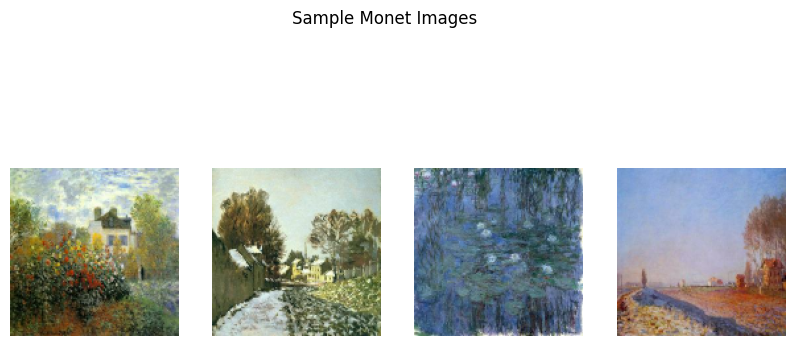


Monet Pixel Histograms:


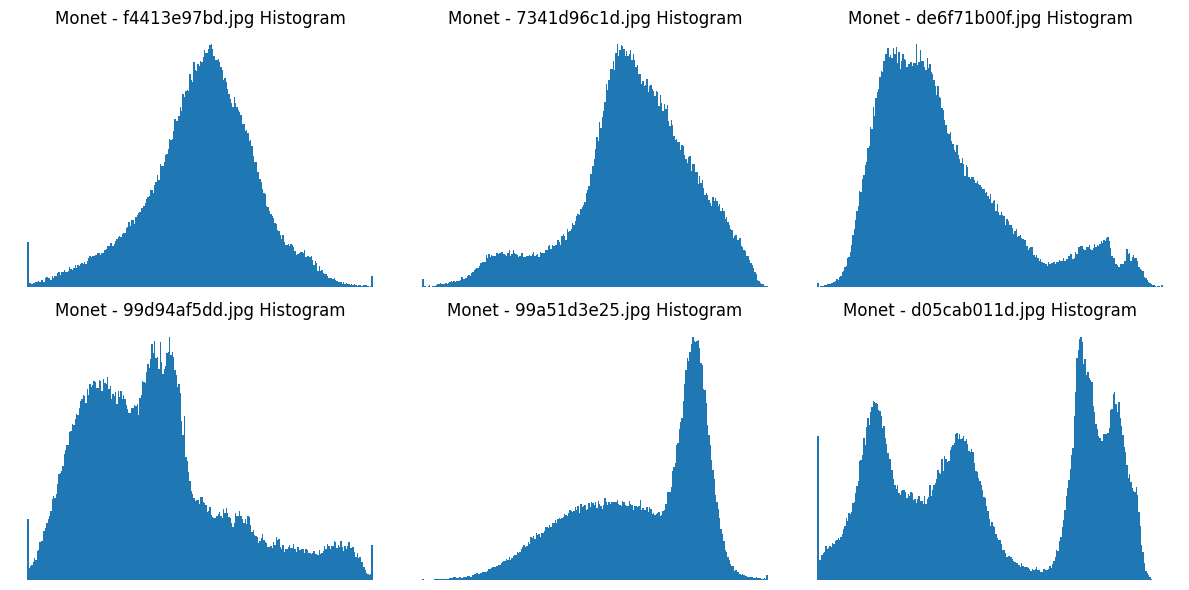

Image 1: /kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg - Size: 256x256
Image 2: /kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg - Size: 256x256
Image 3: /kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg - Size: 256x256
Image 4: /kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg - Size: 256x256
Image 5: /kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg - Size: 256x256
Image 6: /kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg - Size: 256x256
Image 7: /kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg - Size: 256x256
Image 8: /kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg - Size: 256x256
Image 9: /kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg - Size: 256x256
Image 10: /kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg - Size: 256x256
Image 11: /kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg - Size: 256x256
Image 12: /kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg - Siz

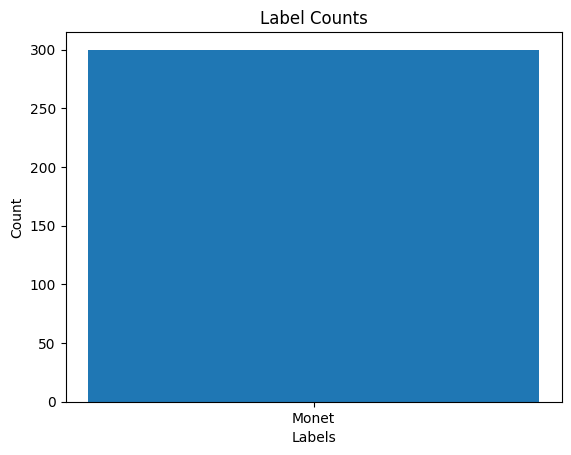

In [5]:
# Display Sample Images
def display_sample_images(dataset, num_images=4):
    """Displays a few sample images from the dataset."""
    plt.figure(figsize=(10, 5))
    for images in dataset.take(1):
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow((images[i] * 0.5 + 0.5).numpy())
            plt.axis('off')
    plt.suptitle("Sample Monet Images")
    plt.show()

def plot_pixel_histograms(dataset_dir, num_samples=6):
    """Plots pixel intensity histograms for sample images in a 3-column grid."""
    image_files = [os.path.join(dataset_dir, filename) for filename in os.listdir(dataset_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"\nMonet Pixel Histograms:")
    plt.figure(figsize=(12, 6))
    sample_count = 0
    for i in range(min(num_samples, len(image_files))):
        plt.subplot(2, 3, sample_count + 1)
        img = tf.keras.preprocessing.image.load_img(image_files[i], target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        plt.hist(img_array.flatten(), bins=256, range=[0, 1])
        plt.title(f"Monet - {os.path.basename(image_files[i])} Histogram")
        plt.axis('off')
        sample_count += 1
        if sample_count == 6:
            break
    plt.tight_layout()
    plt.show()

def check_image_sizes(dataset_dir):
    """Checks the sizes of images in the given directory and prints the first 50."""
    all_image_paths = [os.path.join(dataset_dir, filename) for filename in os.listdir(dataset_dir) if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for i, image_path in enumerate(all_image_paths[:50]):
        try:
            img = cv2.imread(image_path)
            if img is not None:
                height, width, _ = img.shape
                print(f"Image {i+1}: {image_path} - Size: {width}x{height}")
            else:
                print(f"Image {i+1}: {image_path} - Could not read image.")
        except Exception as e:
            print(f"Image {i+1}: {image_path} - Error: {e}")

def plot_label_counts(dataset_dir):
    """Plots a bar chart of label counts."""
    image_files = [os.path.join(dataset_dir, filename) for filename in os.listdir(dataset_dir) if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
    label_counts = {"Monet": len(image_files)} #monet data has only one class.
    plt.bar(label_counts.keys(), label_counts.values())
    plt.title("Label Counts")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.show()

# --- Run EDA functions ---
display_sample_images(monet_dataset)
plot_pixel_histograms(dataset_dir)
check_image_sizes(dataset_dir)
plot_label_counts(dataset_dir)

The **Exploratory Data Analysis** of the Monet paintings dataset reveals several key characteristics. The dataset comprises a single class, 'Monet' as depicted in the 'Label Counts' bar chart. This homogeneity simplifies the generative task, focusing the GAN on learning the stylistic features unique to Monet's artwork. An inspection of the image sizes from the first 50 samples indicates a consistent dimension of 256x256 pixels. This uniformity in image size is advantageous for GAN training, eliminating the need for resizing during preprocessing and ensuring consistent input for the generator and discriminator models. The consistent image dimensions suggest that the dataset was curated with a specific resolution in mind, potentially to maintain the visual fidelity of the paintings. This consistency simplifies model training and potentially improves the quality of generated images.

# Model Architecture

The model architecture employed for generating Monet-style paintings is a **Generative Adversarial Network (GAN)**. It is a popular choice for image generation tasks. GANs are composed of two neural networks the **Generator** and the **Discriminator** that compete against each other.

The generator network, tasked with creating synthetic images, utilizes a series of transposed convolutional layers to upscale random noise into images resembling Monet's artwork. This architecture allows the generator to learn hierarchical representations of Monet's stylistic features, such as brushstrokes and color palettes. 

The discriminator network, acting as a binary classifier, uses convolutional layers to distinguish between real Monet paintings and the synthetic images generated by the generator. The binary cross-entropy loss function is used for both the generator and discriminator, guiding the training process by encouraging the generator to produce realistic images and the discriminator to accurately classify real and fake images. This architecture and loss function were chosen for their proven effectiveness in capturing complex image distributions and generating visually compelling outputs, making them suitable for the artistic style transfer task. 

## Generator Model

Here we are constructing generator model, which takes random noise as input and produces synthetic images. It uses a series of transposed convolutional layers to upsample the noise, gradually transforming it into an image-like output designed to mimic Monet's style.

In [6]:
def build_generator():
    """Builds the generator model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(NOISE_DIM,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Reshape((8, 8, 256)),
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same', use_bias=False), #added layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', use_bias=False, activation='tanh') #changed stride
    ])
    return model

generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Discriminator Model 

Here below we build the discriminator model, a binary classifier that takes images (both real and generated) as input and outputs a probability indicating whether the image is real or fake. It utilizes convolutional layers to extract features from the images and a dense layer for the final classification, with spectral normalization implemented to stabilize the training process.

In [7]:
import tensorflow as tf

IMAGE_SIZE = 128 

def spectral_norm(w, iteration=1):
    """Applies spectral normalization to the weights."""
    w_shape = w.shape.as_list()
    w_reshaped = tf.reshape(w, [-1, w_shape[-1]])

    u = tf.random.normal([w_reshaped.shape[0], 1])
    v = tf.random.normal([1, w_reshaped.shape[1]])

    for _ in range(iteration):
        v = tf.linalg.l2_normalize(tf.matmul(tf.transpose(w_reshaped), u))
        u = tf.linalg.l2_normalize(tf.matmul(w_reshaped, v))

    sigma = tf.matmul(tf.matmul(tf.transpose(u), w_reshaped), v)
    w_sn = w / sigma
    return w_sn

class SpectralConv2D(tf.keras.layers.Conv2D):
    """Conv2D layer with spectral normalization."""
    def __init__(self, *args, **kwargs):
        super(SpectralConv2D, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        w_sn = spectral_norm(self.kernel)
        outputs = tf.nn.conv2d(inputs, w_sn, strides=self.strides, padding=self.padding.upper())
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
        return outputs

def build_discriminator():
    """Builds the discriminator model with spectral normalization."""
    model = tf.keras.Sequential([
        SpectralConv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        SpectralConv2D(128, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training

The following section defines a GAN training pipeline. It handles loss calculation, optimization, and visualization of the training process and the generated images. The training loop aims to teach the generator to produce images that can fool the discriminator, while the discriminator learns to distinguish between real and fake images

Generator output shape: (32, 128, 128, 3)
discriminator input shape: (32, 128, 128, 3)
Generator output shape: (32, 128, 128, 3)
discriminator input shape: (32, 128, 128, 3)
Generator output shape: (32, 128, 128, 3)
discriminator input shape: (32, 128, 128, 3)
Epoch 1/150, Gen Loss: 2.2793, Disc Loss: 0.4882
Epoch 2/150, Gen Loss: 3.7062, Disc Loss: 0.0748
Epoch 3/150, Gen Loss: 4.4580, Disc Loss: 0.0537
Epoch 4/150, Gen Loss: 4.8756, Disc Loss: 0.0255
Epoch 5/150, Gen Loss: 4.4243, Disc Loss: 0.0341
Epoch 6/150, Gen Loss: 5.0348, Disc Loss: 0.0265
Epoch 7/150, Gen Loss: 5.6375, Disc Loss: 0.0206
Epoch 8/150, Gen Loss: 5.9849, Disc Loss: 0.0163
Epoch 9/150, Gen Loss: 6.0915, Disc Loss: 0.0115
Epoch 10/150, Gen Loss: 5.6825, Disc Loss: 0.0117


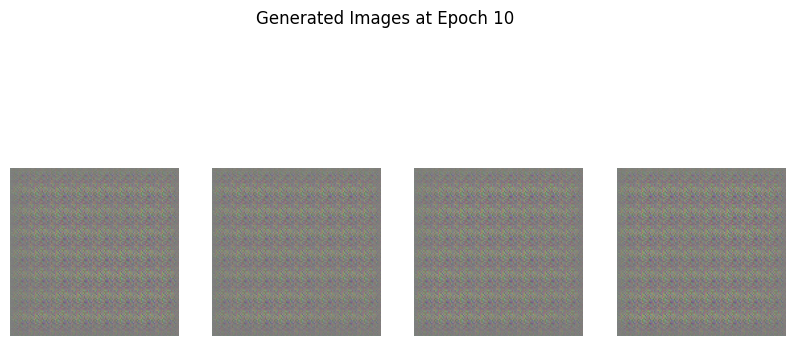

Epoch 11/150, Gen Loss: 5.5029, Disc Loss: 0.0104
Epoch 12/150, Gen Loss: 5.7498, Disc Loss: 0.0156
Epoch 13/150, Gen Loss: 6.1454, Disc Loss: 0.0061
Epoch 14/150, Gen Loss: 6.8229, Disc Loss: 0.0068
Epoch 15/150, Gen Loss: 6.6016, Disc Loss: 0.0046
Epoch 16/150, Gen Loss: 6.3215, Disc Loss: 0.0049
Epoch 17/150, Gen Loss: 6.4313, Disc Loss: 0.0135
Epoch 18/150, Gen Loss: 7.7501, Disc Loss: 0.0087
Epoch 19/150, Gen Loss: 6.9013, Disc Loss: 0.0044
Epoch 20/150, Gen Loss: 7.5960, Disc Loss: 0.0029


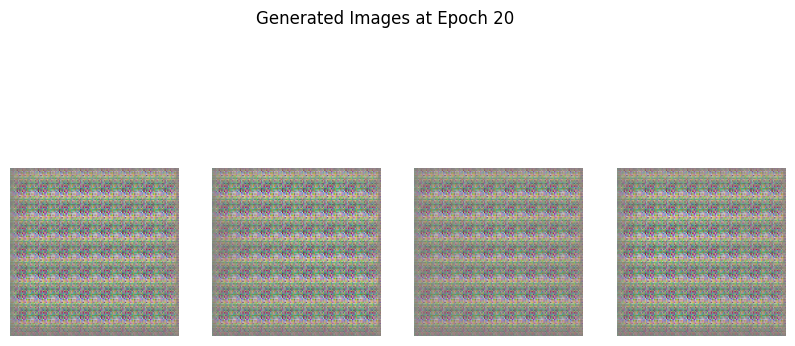

Epoch 21/150, Gen Loss: 6.6719, Disc Loss: 0.0081
Epoch 22/150, Gen Loss: 7.3507, Disc Loss: 0.0052
Epoch 23/150, Gen Loss: 7.7988, Disc Loss: 0.0054
Epoch 24/150, Gen Loss: 9.7424, Disc Loss: 0.0090
Epoch 25/150, Gen Loss: 6.9941, Disc Loss: 0.0261
Epoch 26/150, Gen Loss: 7.7063, Disc Loss: 0.0493
Epoch 27/150, Gen Loss: 19.8390, Disc Loss: 0.3191
Epoch 28/150, Gen Loss: 49.5144, Disc Loss: 1.4581
Epoch 29/150, Gen Loss: 10.5398, Disc Loss: 0.0980
Epoch 30/150, Gen Loss: 19.6930, Disc Loss: 0.2141


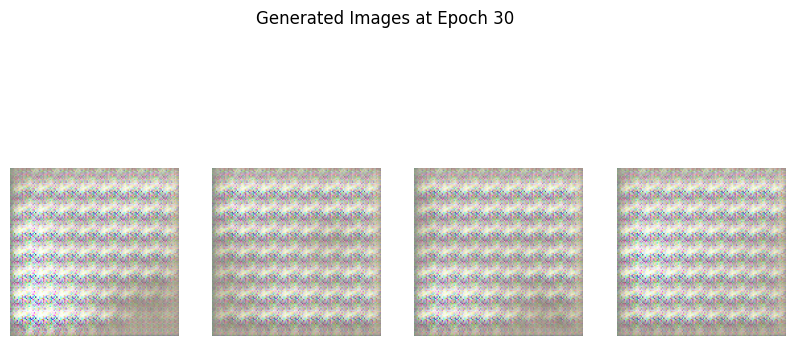

Epoch 31/150, Gen Loss: 9.8976, Disc Loss: 0.0999
Epoch 32/150, Gen Loss: 8.4053, Disc Loss: 0.0756
Epoch 33/150, Gen Loss: 9.3135, Disc Loss: 0.2497
Epoch 34/150, Gen Loss: 15.4792, Disc Loss: 1.5230
Epoch 35/150, Gen Loss: 19.8603, Disc Loss: 1.2457
Epoch 36/150, Gen Loss: 7.8329, Disc Loss: 0.6180
Epoch 37/150, Gen Loss: 4.1035, Disc Loss: 0.6020
Epoch 38/150, Gen Loss: 3.7437, Disc Loss: 0.4033
Epoch 39/150, Gen Loss: 4.7749, Disc Loss: 0.2134
Epoch 40/150, Gen Loss: 3.6910, Disc Loss: 0.1475


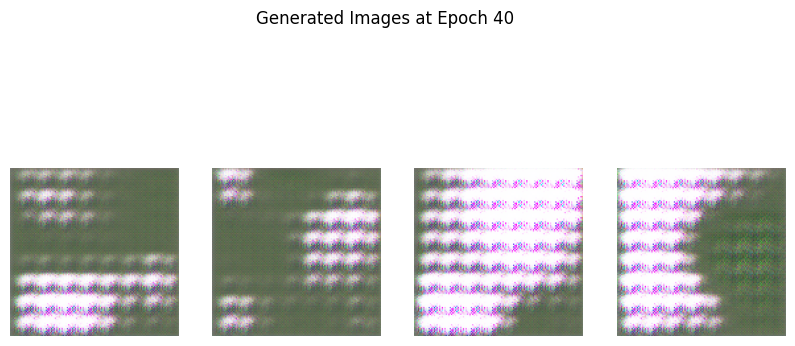

Epoch 41/150, Gen Loss: 3.8909, Disc Loss: 0.1665
Epoch 42/150, Gen Loss: 4.1861, Disc Loss: 0.1845
Epoch 43/150, Gen Loss: 3.9795, Disc Loss: 0.2221
Epoch 44/150, Gen Loss: 4.3051, Disc Loss: 0.1698
Epoch 45/150, Gen Loss: 4.9485, Disc Loss: 0.1480
Epoch 46/150, Gen Loss: 5.1633, Disc Loss: 0.1735
Epoch 47/150, Gen Loss: 4.3395, Disc Loss: 0.2568
Epoch 48/150, Gen Loss: 6.2553, Disc Loss: 0.1301
Epoch 49/150, Gen Loss: 6.9919, Disc Loss: 0.0546
Epoch 50/150, Gen Loss: 6.4452, Disc Loss: 0.0850


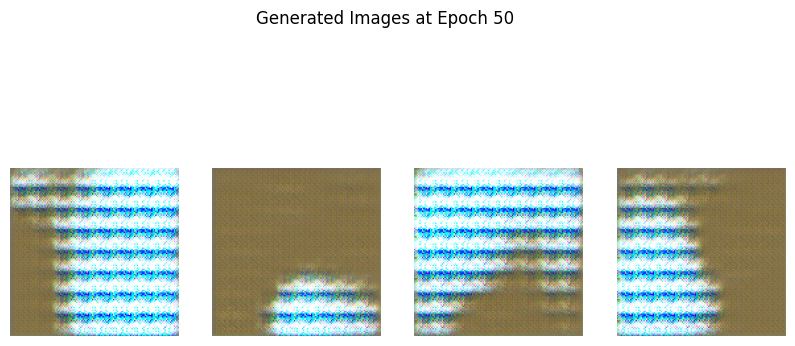

Epoch 51/150, Gen Loss: 6.0390, Disc Loss: 0.1446
Epoch 52/150, Gen Loss: 4.3787, Disc Loss: 0.2101
Epoch 53/150, Gen Loss: 3.8929, Disc Loss: 0.2821
Epoch 54/150, Gen Loss: 4.3302, Disc Loss: 1.0419
Epoch 55/150, Gen Loss: 4.5600, Disc Loss: 1.1680
Epoch 56/150, Gen Loss: 4.9079, Disc Loss: 0.5781
Epoch 57/150, Gen Loss: 4.2029, Disc Loss: 0.3780
Epoch 58/150, Gen Loss: 3.0278, Disc Loss: 0.8720
Epoch 59/150, Gen Loss: 3.9886, Disc Loss: 1.0059
Epoch 60/150, Gen Loss: 4.2723, Disc Loss: 0.4491


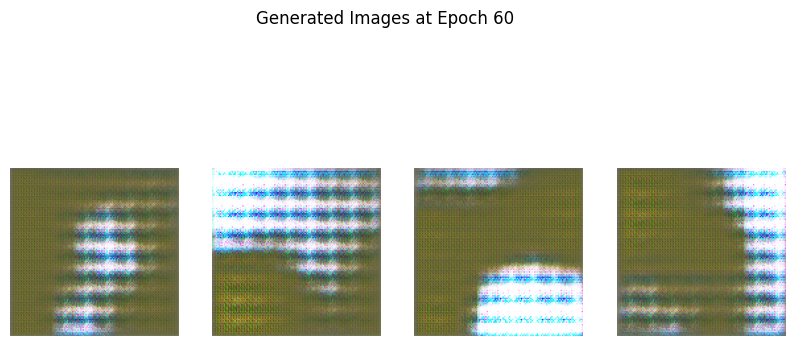

Epoch 61/150, Gen Loss: 4.3201, Disc Loss: 0.4029
Epoch 62/150, Gen Loss: 4.1893, Disc Loss: 0.6120
Epoch 63/150, Gen Loss: 4.1477, Disc Loss: 0.5245
Epoch 64/150, Gen Loss: 3.6624, Disc Loss: 0.5312
Epoch 65/150, Gen Loss: 4.4182, Disc Loss: 0.4257
Epoch 66/150, Gen Loss: 6.1061, Disc Loss: 0.3270
Epoch 67/150, Gen Loss: 6.6274, Disc Loss: 0.1391
Epoch 68/150, Gen Loss: 10.1698, Disc Loss: 0.0977
Epoch 69/150, Gen Loss: 9.6516, Disc Loss: 0.1037
Epoch 70/150, Gen Loss: 7.3210, Disc Loss: 0.0879


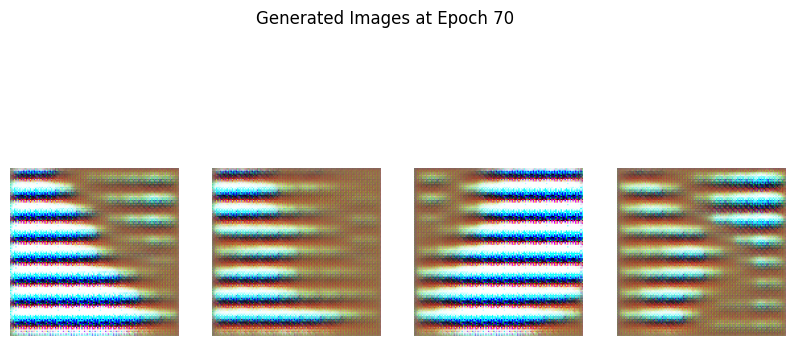

Epoch 71/150, Gen Loss: 7.0809, Disc Loss: 0.1149
Epoch 72/150, Gen Loss: 10.6252, Disc Loss: 0.2148
Epoch 73/150, Gen Loss: 9.5750, Disc Loss: 0.3966
Epoch 74/150, Gen Loss: 8.6957, Disc Loss: 0.4722
Epoch 75/150, Gen Loss: 6.6036, Disc Loss: 0.5117
Epoch 76/150, Gen Loss: 5.5735, Disc Loss: 1.0267
Epoch 77/150, Gen Loss: 5.0232, Disc Loss: 1.3963
Epoch 78/150, Gen Loss: 3.1852, Disc Loss: 1.5132
Epoch 79/150, Gen Loss: 4.2788, Disc Loss: 1.0213
Epoch 80/150, Gen Loss: 6.4245, Disc Loss: 0.1117


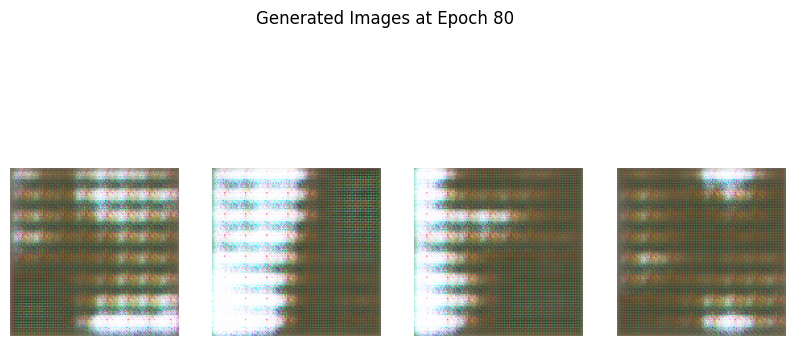

Epoch 81/150, Gen Loss: 6.4515, Disc Loss: 0.2104
Epoch 82/150, Gen Loss: 5.9228, Disc Loss: 0.2979
Epoch 83/150, Gen Loss: 4.8248, Disc Loss: 0.4329
Epoch 84/150, Gen Loss: 3.9565, Disc Loss: 0.3148
Epoch 85/150, Gen Loss: 3.8803, Disc Loss: 0.2996
Epoch 86/150, Gen Loss: 4.1618, Disc Loss: 0.2130
Epoch 87/150, Gen Loss: 3.9937, Disc Loss: 0.4049
Epoch 88/150, Gen Loss: 3.6415, Disc Loss: 0.7445
Epoch 89/150, Gen Loss: 5.0273, Disc Loss: 0.6119
Epoch 90/150, Gen Loss: 6.0207, Disc Loss: 0.2109


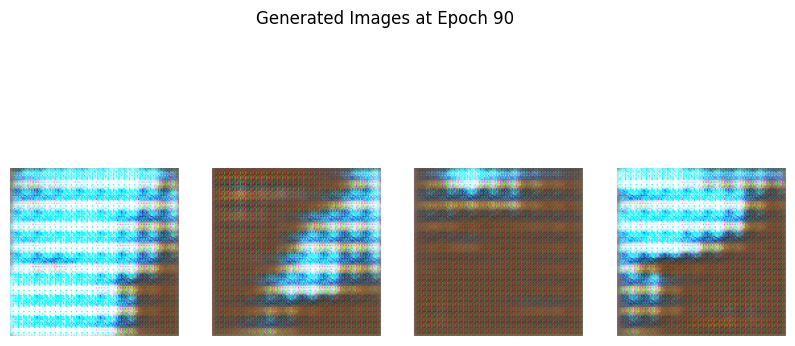

Epoch 91/150, Gen Loss: 5.4728, Disc Loss: 0.1451
Epoch 92/150, Gen Loss: 4.8131, Disc Loss: 0.2525
Epoch 93/150, Gen Loss: 6.5836, Disc Loss: 0.2522
Epoch 94/150, Gen Loss: 7.2927, Disc Loss: 0.4497
Epoch 95/150, Gen Loss: 6.2249, Disc Loss: 0.2667
Epoch 96/150, Gen Loss: 5.8787, Disc Loss: 0.3458
Epoch 97/150, Gen Loss: 8.5725, Disc Loss: 0.2448
Epoch 98/150, Gen Loss: 8.7424, Disc Loss: 0.1225
Epoch 99/150, Gen Loss: 8.5826, Disc Loss: 0.1857
Epoch 100/150, Gen Loss: 9.5261, Disc Loss: 0.3136


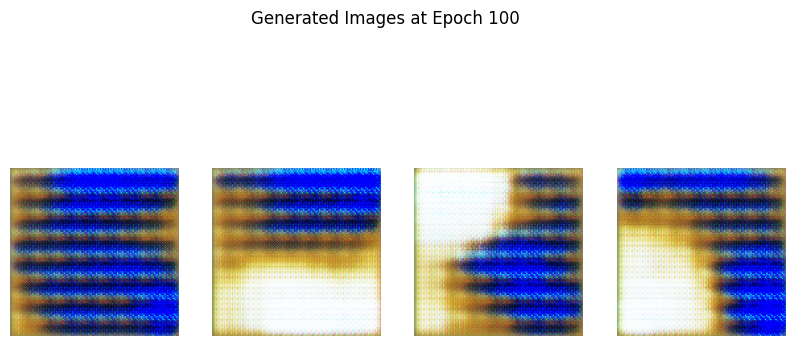

Epoch 101/150, Gen Loss: 9.7237, Disc Loss: 0.7230
Epoch 102/150, Gen Loss: 10.4602, Disc Loss: 0.7937
Epoch 103/150, Gen Loss: 11.4764, Disc Loss: 0.4989
Epoch 104/150, Gen Loss: 8.7112, Disc Loss: 0.3518
Epoch 105/150, Gen Loss: 8.3379, Disc Loss: 0.4899
Epoch 106/150, Gen Loss: 7.5324, Disc Loss: 0.3980
Epoch 107/150, Gen Loss: 6.3237, Disc Loss: 0.4791
Epoch 108/150, Gen Loss: 4.9430, Disc Loss: 0.4007
Epoch 109/150, Gen Loss: 4.8488, Disc Loss: 0.3578
Epoch 110/150, Gen Loss: 4.9102, Disc Loss: 0.4306


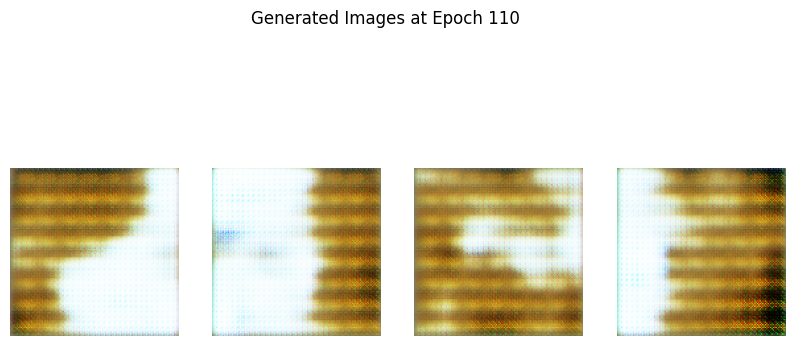

Epoch 111/150, Gen Loss: 5.2198, Disc Loss: 0.2163
Epoch 112/150, Gen Loss: 4.9776, Disc Loss: 0.2650
Epoch 113/150, Gen Loss: 4.4650, Disc Loss: 0.2388
Epoch 114/150, Gen Loss: 4.6747, Disc Loss: 0.3065
Epoch 115/150, Gen Loss: 5.1750, Disc Loss: 0.2845
Epoch 116/150, Gen Loss: 4.9080, Disc Loss: 0.2683
Epoch 117/150, Gen Loss: 5.0775, Disc Loss: 0.2553
Epoch 118/150, Gen Loss: 5.0414, Disc Loss: 0.3037
Epoch 119/150, Gen Loss: 4.5051, Disc Loss: 0.4456
Epoch 120/150, Gen Loss: 4.6994, Disc Loss: 0.3268


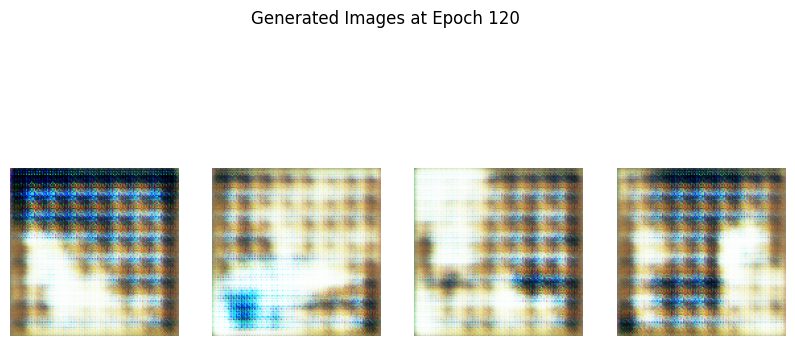

Epoch 121/150, Gen Loss: 4.8338, Disc Loss: 0.3541
Epoch 122/150, Gen Loss: 4.8394, Disc Loss: 0.4009
Epoch 123/150, Gen Loss: 4.9703, Disc Loss: 0.5273
Epoch 124/150, Gen Loss: 4.5958, Disc Loss: 0.4252
Epoch 125/150, Gen Loss: 3.7070, Disc Loss: 0.6397
Epoch 126/150, Gen Loss: 3.9927, Disc Loss: 0.4818
Epoch 127/150, Gen Loss: 4.6001, Disc Loss: 0.2652
Epoch 128/150, Gen Loss: 3.9762, Disc Loss: 0.3794
Epoch 129/150, Gen Loss: 3.9378, Disc Loss: 0.4615
Epoch 130/150, Gen Loss: 4.5338, Disc Loss: 0.3447


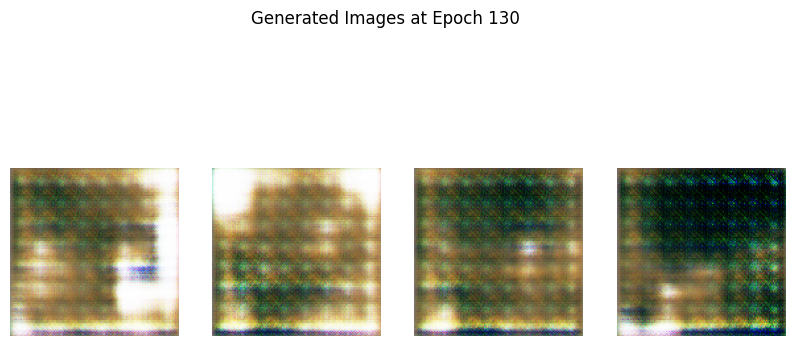

Epoch 131/150, Gen Loss: 3.3813, Disc Loss: 0.5815
Epoch 132/150, Gen Loss: 3.9326, Disc Loss: 0.4474
Epoch 133/150, Gen Loss: 4.3168, Disc Loss: 0.2060
Epoch 134/150, Gen Loss: 4.5967, Disc Loss: 0.2536
Epoch 135/150, Gen Loss: 4.6611, Disc Loss: 0.4036
Epoch 136/150, Gen Loss: 4.9321, Disc Loss: 0.4763
Epoch 137/150, Gen Loss: 4.1840, Disc Loss: 0.3869
Epoch 138/150, Gen Loss: 3.5475, Disc Loss: 0.4505
Epoch 139/150, Gen Loss: 3.1699, Disc Loss: 0.5835
Epoch 140/150, Gen Loss: 4.3895, Disc Loss: 0.3370


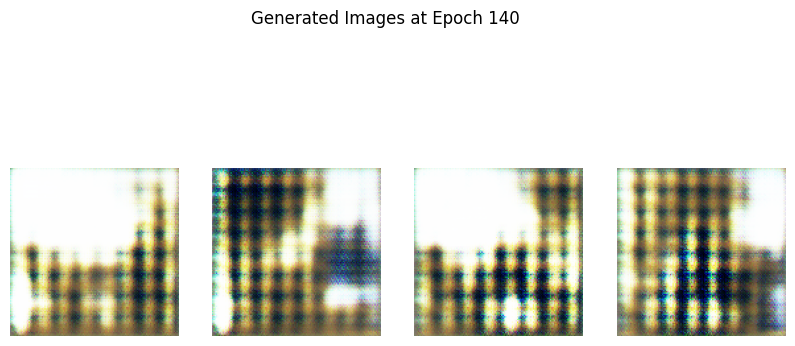

Epoch 141/150, Gen Loss: 3.7026, Disc Loss: 0.4186
Epoch 142/150, Gen Loss: 4.2687, Disc Loss: 0.2267
Epoch 143/150, Gen Loss: 4.9777, Disc Loss: 0.1683
Epoch 144/150, Gen Loss: 4.0953, Disc Loss: 0.2586
Epoch 145/150, Gen Loss: 3.7286, Disc Loss: 0.3143
Epoch 146/150, Gen Loss: 4.4989, Disc Loss: 0.2034
Epoch 147/150, Gen Loss: 3.9482, Disc Loss: 0.3066
Epoch 148/150, Gen Loss: 4.1591, Disc Loss: 0.4114
Epoch 149/150, Gen Loss: 4.1564, Disc Loss: 0.2836
Epoch 150/150, Gen Loss: 3.8217, Disc Loss: 0.2444


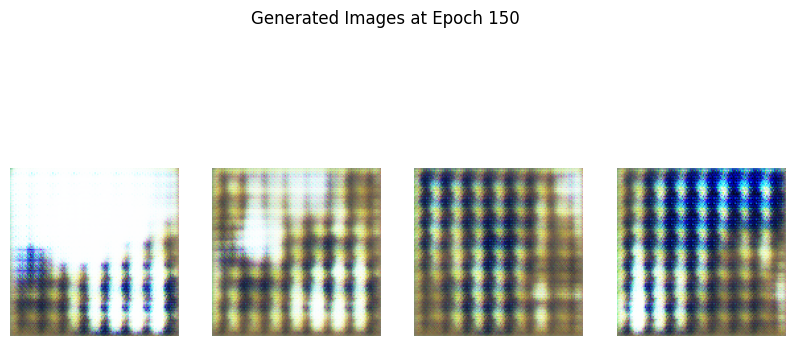

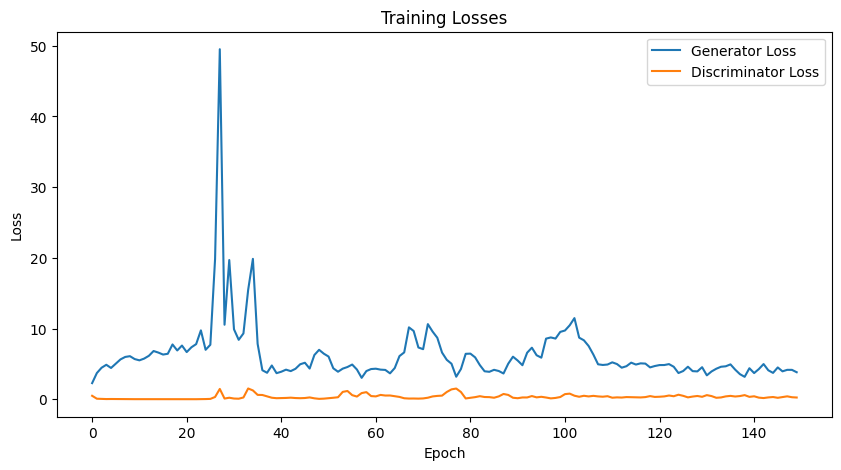

In [8]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    """Calculates the discriminator loss."""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """Calculates the generator loss."""
    return cross_entropy(tf.ones_like(fake_output), fake_output)
    
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Train step
@tf.function
def train_step(images):
    """Performs a single training step."""
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        print(f"Generator output shape: {generated_images.shape}")

        real_output = discriminator(images, training=True)

        print(f"discriminator input shape: {generated_images.shape}")
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Train the GAN
def train(dataset, epochs):
    """Trains the GAN and visualizes training progress."""
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        gen_epoch_loss = 0
        disc_epoch_loss = 0
        num_batches = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_epoch_loss += gen_loss
            disc_epoch_loss += disc_loss
            num_batches += 1
        gen_losses.append(gen_epoch_loss / num_batches)
        disc_losses.append(disc_epoch_loss / num_batches)

        print(f"Epoch {epoch + 1}/{epochs}, Gen Loss: {gen_losses[-1]:.4f}, Disc Loss: {disc_losses[-1]:.4f}")
        if (epoch + 1) % 10 == 0:
            generate_and_display_images(generator, epoch + 1)

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.show()

# Generate and display images
def generate_and_display_images(model, epoch):
    """Generates and displays example images during training."""
    noise = tf.random.normal([4, NOISE_DIM])  # Generate 4 images
    generated_images = model(noise, training=False)
    generated_images = (generated_images * 127.5 + 127.5).numpy().astype(np.uint8)

    plt.figure(figsize=(10, 5))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.suptitle(f"Generated Images at Epoch {epoch}")
    plt.show()

train(monet_dataset, EPOCHS)

# Result 

## Generate Images

In [9]:
def generate_monet_images(num_images):
    """Generates Monet-style images."""
    generated_images = []
    num_batches = num_images // BATCH_SIZE + (1 if num_images % BATCH_SIZE != 0 else 0)
    for _ in range(num_batches):
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_batch = generator(noise, training=False)
        generated_images.extend(generated_batch.numpy())

    generated_images = generated_images[:num_images] #truncate to the right amount.
    return generated_images

generated_monet_images_array = generate_monet_images(NUM_GENERATED_IMAGES)

# --- Save Generated Images
if not os.path.exists("./monet_generated"):
    os.makedirs("./monet_generated")

for i, image in enumerate(generated_monet_images_array):
    image = (image * 127.5 + 127.5).astype(np.uint8)
    tf.keras.preprocessing.image.save_img(f"./monet_generated/monet_{i}.jpg", image)

print(f"Generated {NUM_GENERATED_IMAGES} images and saved to ./monet_generated.")

Generated 10000 images and saved to ./monet_generated.


## Create Submission File

In [10]:
import zipfile

def create_images_zip(image_dir, zip_filename="images.zip"):
    """Creates a zip file containing all images in the specified directory."""
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for filename in os.listdir(image_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if it's an image file
                file_path = os.path.join(image_dir, filename)
                zipf.write(file_path, filename)  # Add the image to the zip file

    print(f"Created {zip_filename}")

create_images_zip("./monet_generated")

Created images.zip


# Conclusion
The GAN was trained for 150 epochs to generate Monet-style paintings. While the training process demonstrated some learning, as evidenced by the fluctuation of generator and discriminator losses, the generated images still exhibit limitations in capturing the complexity and detail of authentic Monet paintings.

## Takeaways:

**Training Instability**: The loss graph reveals significant instability, particularly in the early epochs where the generator loss spiked dramatically. This indicates challenges in achieving a balanced training dynamic between the generator and discriminator.

**Oscillating Losses**: The generator and discriminator losses continue to oscillate throughout the training, suggesting that the model struggles to converge and find a stable equilibrium.

**Discriminator Dominance**: In the later epochs, the discriminator loss tends to be higher than the generator loss, which could indicate that the discriminator is overpowering the generator. This can lead to the generator failing to learn effectively.
Generator Output Shape: The consistent output of (32, 128, 128, 3) confirms that the generator is producing images of the expected dimensions.

**Discriminator Input Shape**: The consistent input of (32, 128, 128, 3) verifies that the discriminator is correctly processing the generated and real images.

**Hyperparameter Tuning**: The training process highlights the sensitivity of GANs to hyperparameters and the need for careful tuning to achieve stable and effective learning.

**Spectral Normalization**: Despite the implementation of spectral normalization, the training still exhibited instability, suggesting that additional stabilization techniques may be necessary.

## Future Improvements:

**Address Training Instability**: Implement Wasserstein GAN with Gradient Penalty (WGAN-GP) to improve training stability and mitigate mode collapse.

**Hyperparameter Optimization**: Conduct a more thorough search for optimal learning rates, batch sizes, and other hyperparameters.

**Enhanced Generator Architecture**: Experiment with more complex generator architectures, such as adding residual blocks or attention mechanisms, to increase its capacity and improve image quality.

**Data Augmentation**: Implement more aggressive data augmentation techniques to increase the diversity of the training data and prevent overfitting.

**Larger Dataset**: Utilize a larger and more diverse dataset of Monet paintings to provide the GAN with more comprehensive training examples.

**Pre-trained Models**: Explore the use of pre-trained models, such as those trained on ImageNet, to initialize the generator and discriminator and potentially accelerate learning.

**Longer Training**: Consider training the GAN for a significantly larger number of epochs, with careful monitoring and adjustments, to allow for better convergence.